In [12]:
# –––– Purpose of this script –––– 

# Generate a visual representation of agent activities on your helpdesk during the previous day. 
# Each activity appears as a point in a scatter plot, allowing position and alpha-overlap to give a quick impression of activity.

# The script:
# 1. Retrieves the daily activity log from Freshdesk's API
# 2. Retrieves the names and IDs of support agents then converts IDs to names in the log
# 3. Extracts the activities from the log and converts them to readable labels
# 4. Visualises the activity as a report, and saves it as a .png in your working directory.





In [52]:
# –––– Preperations before this script can run –––– 

# Switch on the activities report export in Freshdesk. See here for more info: 
# https://support.freshdesk.com/support/solutions/articles/226460-export-ticket-activities/



# Provide some details:

desk_name = 'your_Freshdesk_account_name'
# This is your Freshdesk URL without '.freshdesk.com' on the end. 
# eg: if your full URL is 'megashop.freshdesk.com' use 'megashop'

auth_deets = ("your_API_key", "your_Freshdesk_password") 
# Your Freshdesk API key is in your Freshdesk profile: https://support.freshdesk.com/support/solutions/articles/215517-how-to-find-your-api-key
# A password must be provided but it does not appear to be verified. I haven't confirmed with Freshdesk if this is a bug. 
# For security's sake, you can leave the password as it is or enter in some humourous nonsense for your own satisfaction. 



# –––– The following two variables are optional. Leaving them as they are will not interfere with your report, but it's worth reading to understand  –––– 

# Actions performed on a ticket by an integration (eg. Freshchat) are labelled as having been performed by whoever's API key was used to set up that integration. 
# This produces some unwanted results (you may have noticed that every ticket created from Freshchat is apparently created by the person whose API key was used)
# There's no obvious way to tweeze the integration activities from the real activities, so it's best to give an explicit label explaining that the intergration is included


admin_ID = '12345678901'
# This is an 11 digit number, which you will see in the URL when editing your profile (assuming that your profile's API key was used for the integration)
# eg: https://megashop.freshdesk.com/a/profiles/12345678901/edit
# You can also run the whole script then view the agent_translate dictionary to see the codes, then enter it above and run again

desired_admin_label = 'Dave or Integration'
# This is what will appear on the final report alongside activities performed by that person or by the integration they set up







In [53]:
# –––– From here on you should be able to run the script without any other input –––– 




In [54]:
# –––– Import libraries –––– 

import requests as r
import json
import pandas as pd
import re
from datetime import *
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
from pylab import rcParams




# –––– Prepare function to report query errors –––– 

def reporter(query):
    if query.status_code != 200:
        print("Query didn't work: ", query.status_code, query.reason, query.url)

        
        
        
# –––– Prepare desk URL for API calls –––– 

desk_URL = 'https://' + desk_name + '.freshdesk.com'





In [55]:
# –––– 1. Retrieve the daily activity log from Freshdesk API –––– 

# Request URL for today's log (generated at midnight every day)
call = r.get(desk_URL + "/api/v2/export/ticket_activities", 
             auth = auth_deets)
reporter(call)

# Convert the response from json to a Python dictionay
response = call.json()

# The URL changes every day so grab the URL from the json
URL = response['export'][0]['url']

# Query the special URL to get the daily activities log
call = r.get(URL)
reporter(call)

# Convert it from the json to start pulling metrics
daily_acts_raw = call.json()

# Index slices remove timezone, which is not recognised by pd.to_datetime
report_start = pd.to_datetime(daily_acts_raw['metadata']['start_at'][:19], format = '%d-%m-%Y %H:%M:%S')
report_end = pd.to_datetime(daily_acts_raw['metadata']['end_at'][:19], format = '%d-%m-%Y %H:%M:%S')






In [56]:
# –––– 2. Retrieve the names and IDs of support agents then convert IDs to names in the log –––– 

call = r.get(desk_URL + '/api/v2/agents.json', 
             auth = auth_deets)
reporter(call)

raw_agents = call.json()

agent_translate = {}

for x in range(len(raw_agents)):
    ID = raw_agents[x]['id']
    name = raw_agents[x]['contact']['name']
    agent_translate[ID] = name

# This will edit the label for the agent whose API key is used for any integrations.
agent_translate[admin_ID] = desired_admin_label






In [57]:
# –––– 3. Extract the activities from the log and convert to readable labels –––– 

activities = daily_acts_raw['activities_data']

# Translate performer_id into readable names 
# This could probably be done with a df.replace function further down but I'm not looking to twiddle too hard right now
for x in range(len(activities)):
    if activities[x]['performer_type']=='user':
        try:
            activities[x]['performer_id'] = agent_translate[activities[x]['performer_id']]
        except:
            activities[x]['performer_id'] = "Customer"
    if activities[x]['performer_type']=='system':
            activities[x]['performer_id'] = "System"


# The items in each activity dictionary are not identical. 
# Loop through them to get a full set, which we can use as column headers
activity_keys = set()
for x, activity in enumerate(activities):
    fields = set(list(activities[x].keys()))
    activity_keys = activity_keys.union(fields)
    
#Convert the list of dicionaries to a dataframe
activitiesdf = pd.DataFrame(activities, columns=activity_keys)

# Convert timestamp strings to datetime
# The timestamps are not in ISO, and has a UTC offset, which I can't get pandas to recognise with %z.
activitiesdf['performed_at'] = pd.to_datetime(activitiesdf['performed_at'].str[:19], format = '%d-%m-%Y %H:%M:%S')


# Create new column with simplified description of the activity
# This section is a bit weird. There must be a cleaner way to do this
simplified_acts = []
for row in activitiesdf['activity']:
    simplified_acts.append(list(row.keys())[0])
# above extracts the first key from the dictionary in each cell and saves it to a list

# then below, we convert those values into the simplified labels we need
for c, x in enumerate(simplified_acts):
    if x != 'note' and x != 'automation':
        simplified_acts[c] = 'Ticket edited'
    if x == 'note':
        simplified_acts[c] = 'Message sent'
    if x == 'automation':
        simplified_acts[c] = 'Automation rule applied'
        
#then we make a dataframe of that list
fordf = pd.DataFrame(simplified_acts)

#then we join the two dataframes
activitiesdf = activitiesdf.join(fordf)

#then we rename the newly added column... Is there a new way of saying 'arse about face'?
activitiesdf.rename(columns = {0:'Activity type'}, inplace = True)






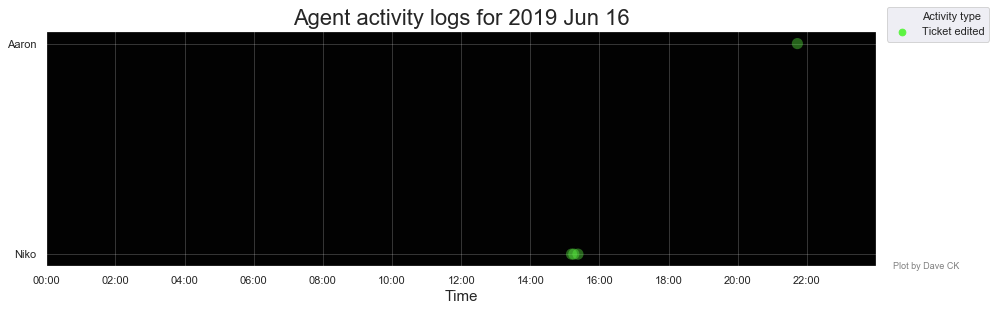

In [105]:
# –––– 4. Visualise the activity as a report –––– 

title = "Agent activity logs for " + report_start.strftime('%Y %b %d')

x = activitiesdf['performed_at'][(activitiesdf['performer_id'] != 'System') & (activitiesdf['performer_id'] != 'Customer')]
y = activitiesdf['performer_id'][(activitiesdf['performer_id'] != 'System') & (activitiesdf['performer_id'] != 'Customer')]
z = activitiesdf['Activity type'][(activitiesdf['performer_id'] != 'System') & (activitiesdf['performer_id'] != 'Customer')]

sns.set(rc={'figure.figsize':(14, len(z.unique()) * 4.5)})

ax = sns.scatterplot(x = x, 
                      y = y,
                      data = activitiesdf,
                      hue = z,
                      palette = {'Message sent' : '#00f6ff', 'Ticket edited' : '#5cf442', 'Automation rule applied' : '#fa00ff'},
                      size = z, 
                      markers = {'Message sent' : 'd', 'Automation rule applied' : 'd', 'Ticket edited' : '.'}, #https://matplotlib.org/1.4.1/api/markers_api.html
                      alpha = 0.4,
                      sizes = (500, 600),
                      legend = 'full',
                      linewidth = 0,
                      style = z,
                   #   figsize = (20,8)
                      )



ax.set_facecolor('#020202')
ax.grid(color = '1', linestyle='-', linewidth = 1, alpha = 0.2)
ax.set(ylabel = None)
ax.axes.set_xlabel('Time', fontsize = 15)
ax.axes.set_title(title, fontsize = 22)
ax.set_xlim(report_start, report_end)

ax.text(1.1, 0, 'Plot by Dave CK', 
        horizontalalignment = 'right', 
        verticalalignment='center', 
        transform = ax.transAxes,
        fontsize = 9,
        color = 'grey') 


ax.xaxis.set_major_locator(matplotlib.dates.HourLocator(interval = 2))
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%H:%M'))


ax.legend(loc = 2, bbox_to_anchor = (1, 1.15), borderaxespad = 1, markerscale = 0.6) 
plt.tight_layout()

plt.savefig('Agent_activity_logs/' + title + '.png', dpi = 100, frameon = False)